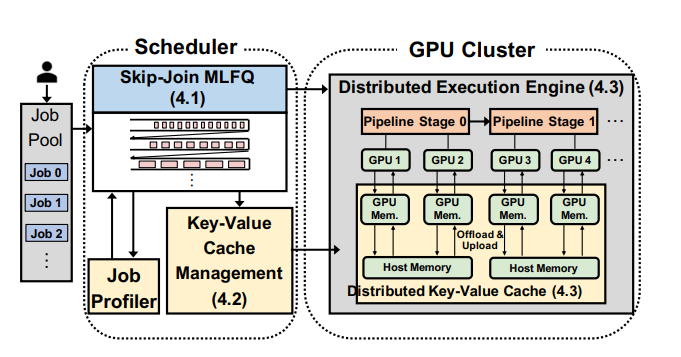

In [ ]:
def get_highest_priority(iteration_time):
  """
  get the priority of the job based on the iteration time
  """
  pass

def  get_demotion_priority(priority, next_iteration_time):
  """
  demote the job the lower priority queue based on the currrent priority and next iteraction time
  """
  pass


def skip_join_mlfq_scheduler(queues, newly_arrived_jobs, preempted_jobs, profiling_info, MAX_BATCH_SIZE=512):


  """
   Skip-join MLFQ scheduler for LLM inference.

  Function Parameters:
    queues: This is a list of queues with their priority level
    newly_arrived_jobs: A list of newly arrived jobs.
    preempted_jobs: A list of preempted jobs.
    profiling_info: A dictionary that maps from job ID to its first iteration time.
                  : We compute the iteraction time based on the time it take to generate the output token

  Returns:
    return a batch of job to be proccessed in our GPU cluster
  """

  # Initialize the output list.
  jobs_to_execute = []

  # Process newly arrived jobs.
  for job in newly_arrived_jobs:
    next_iteration_time = profiling_info[job.id]
    priority = get_highest_priority(next_iteration_time)
    queues[priority].push(job)

  # Process preempted jobs.
  for job in preempted_jobs:
    # send the generated token to the user (better user experience)
    job.output_generated_tokens()

    priority = job.get_current_priority()
    if job.is_finished():
      queues[priority].pop(job)
      continue
    if job.needs_demotion():
      next_iteration_time = profiling_info[job.id]
      demoted_priority = get_demotion_priority(priority, next_iteration_time)
      queues[demoted_priority].push(job)

  # Promote starved jobs.
  for queue in queues[1:]:
    for job in queue:
      if job.needs_promotion():
        job.promote_to(queues[0]) # promote the job to the highest priority queue
        job.reset_starvation_timer()

  # Schedule jobs to be executed.
  for queue in queues:
    for job in queue:
      if job.is_ready() and len(jobs_to_execute) < MAX_BATCH_SIZE:
        jobs_to_execute.append(job)

  return jobs_to_execute # Batch
